### Initial run

Initial end to end test, a sort of a "teaser" to highlight the motivation for `concurrent_dataloader`. 

In [139]:
from benchmarking.analysis.analyze_results import *

In [140]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/motivation/rep-enh-gpu")

In [142]:
s3_folder_filter="*s3*"
scratch_folder_filter="*scratch*"

Load the data

In [143]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 184.51it/s]


Create "colors" and "lanes". Colors are used to distinguish different function types, e.g. function that loads a batch, calls the `next_data`, `run_traning_batch` from Lightning and `training_batch_to_device` also from lightning.
Lanes, every single call of the aforementioned funcitons in their own respective lane, so we get a nice overview of when the function is called, and how long it tookl

Extract the GPU Utilization data

In [144]:
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter, ms=True, skip=8)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:38<00:00,  1.44s/it]


In [145]:
df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter, ms=True, skip=8)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.18it/s]


### Plot function timelines for remote storage (AWS S3)

timestamp_2 True
71.75079149706015 41.055847255369926


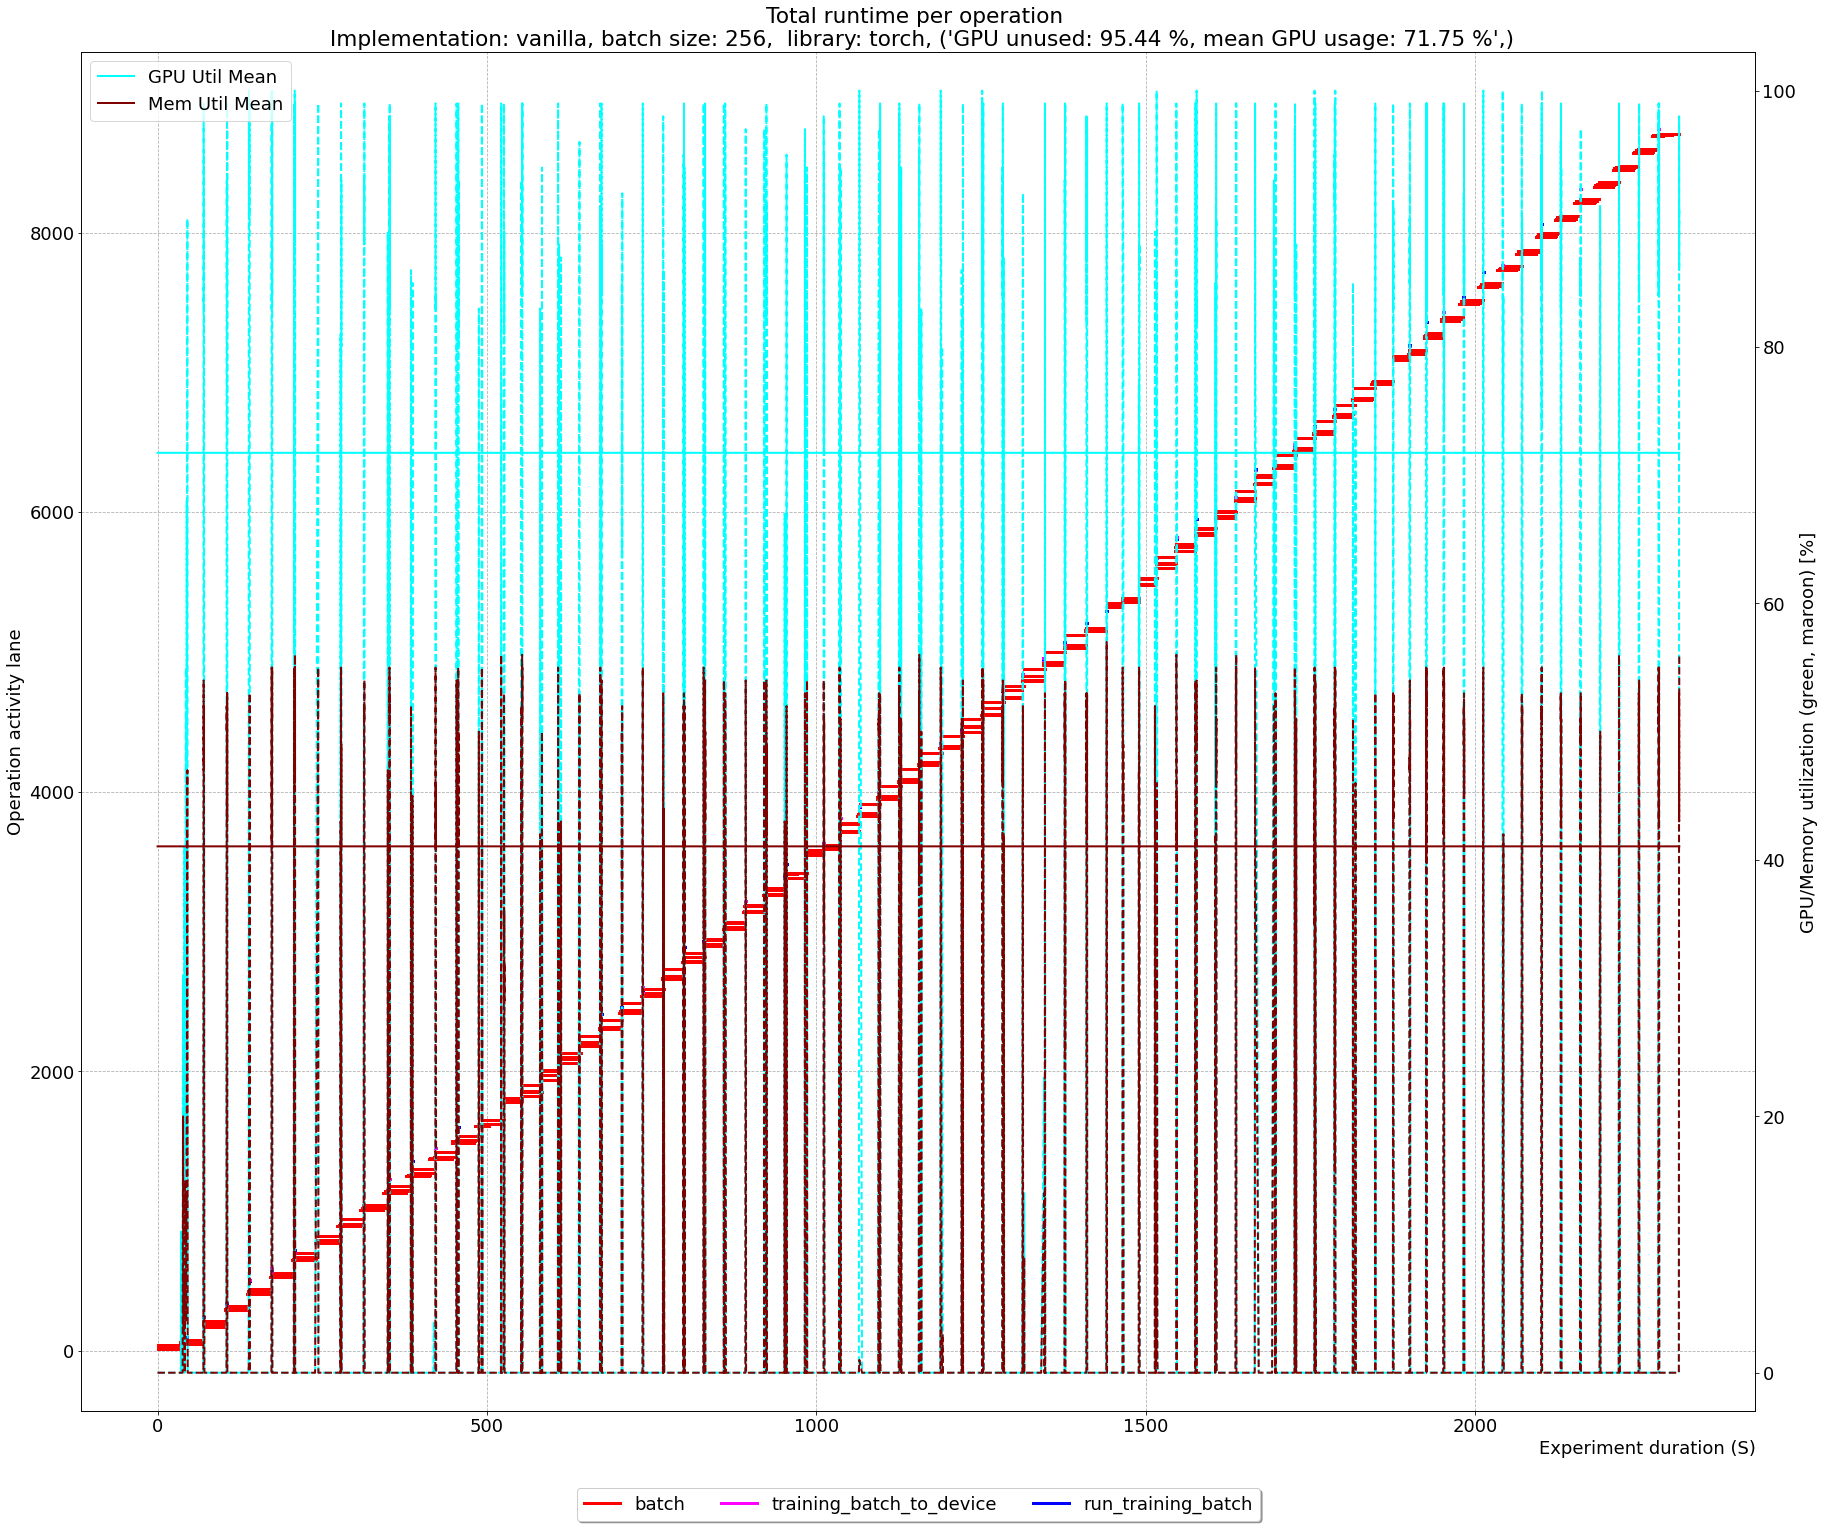

timestamp_2 True
65.28030509397985 19.189587721938008


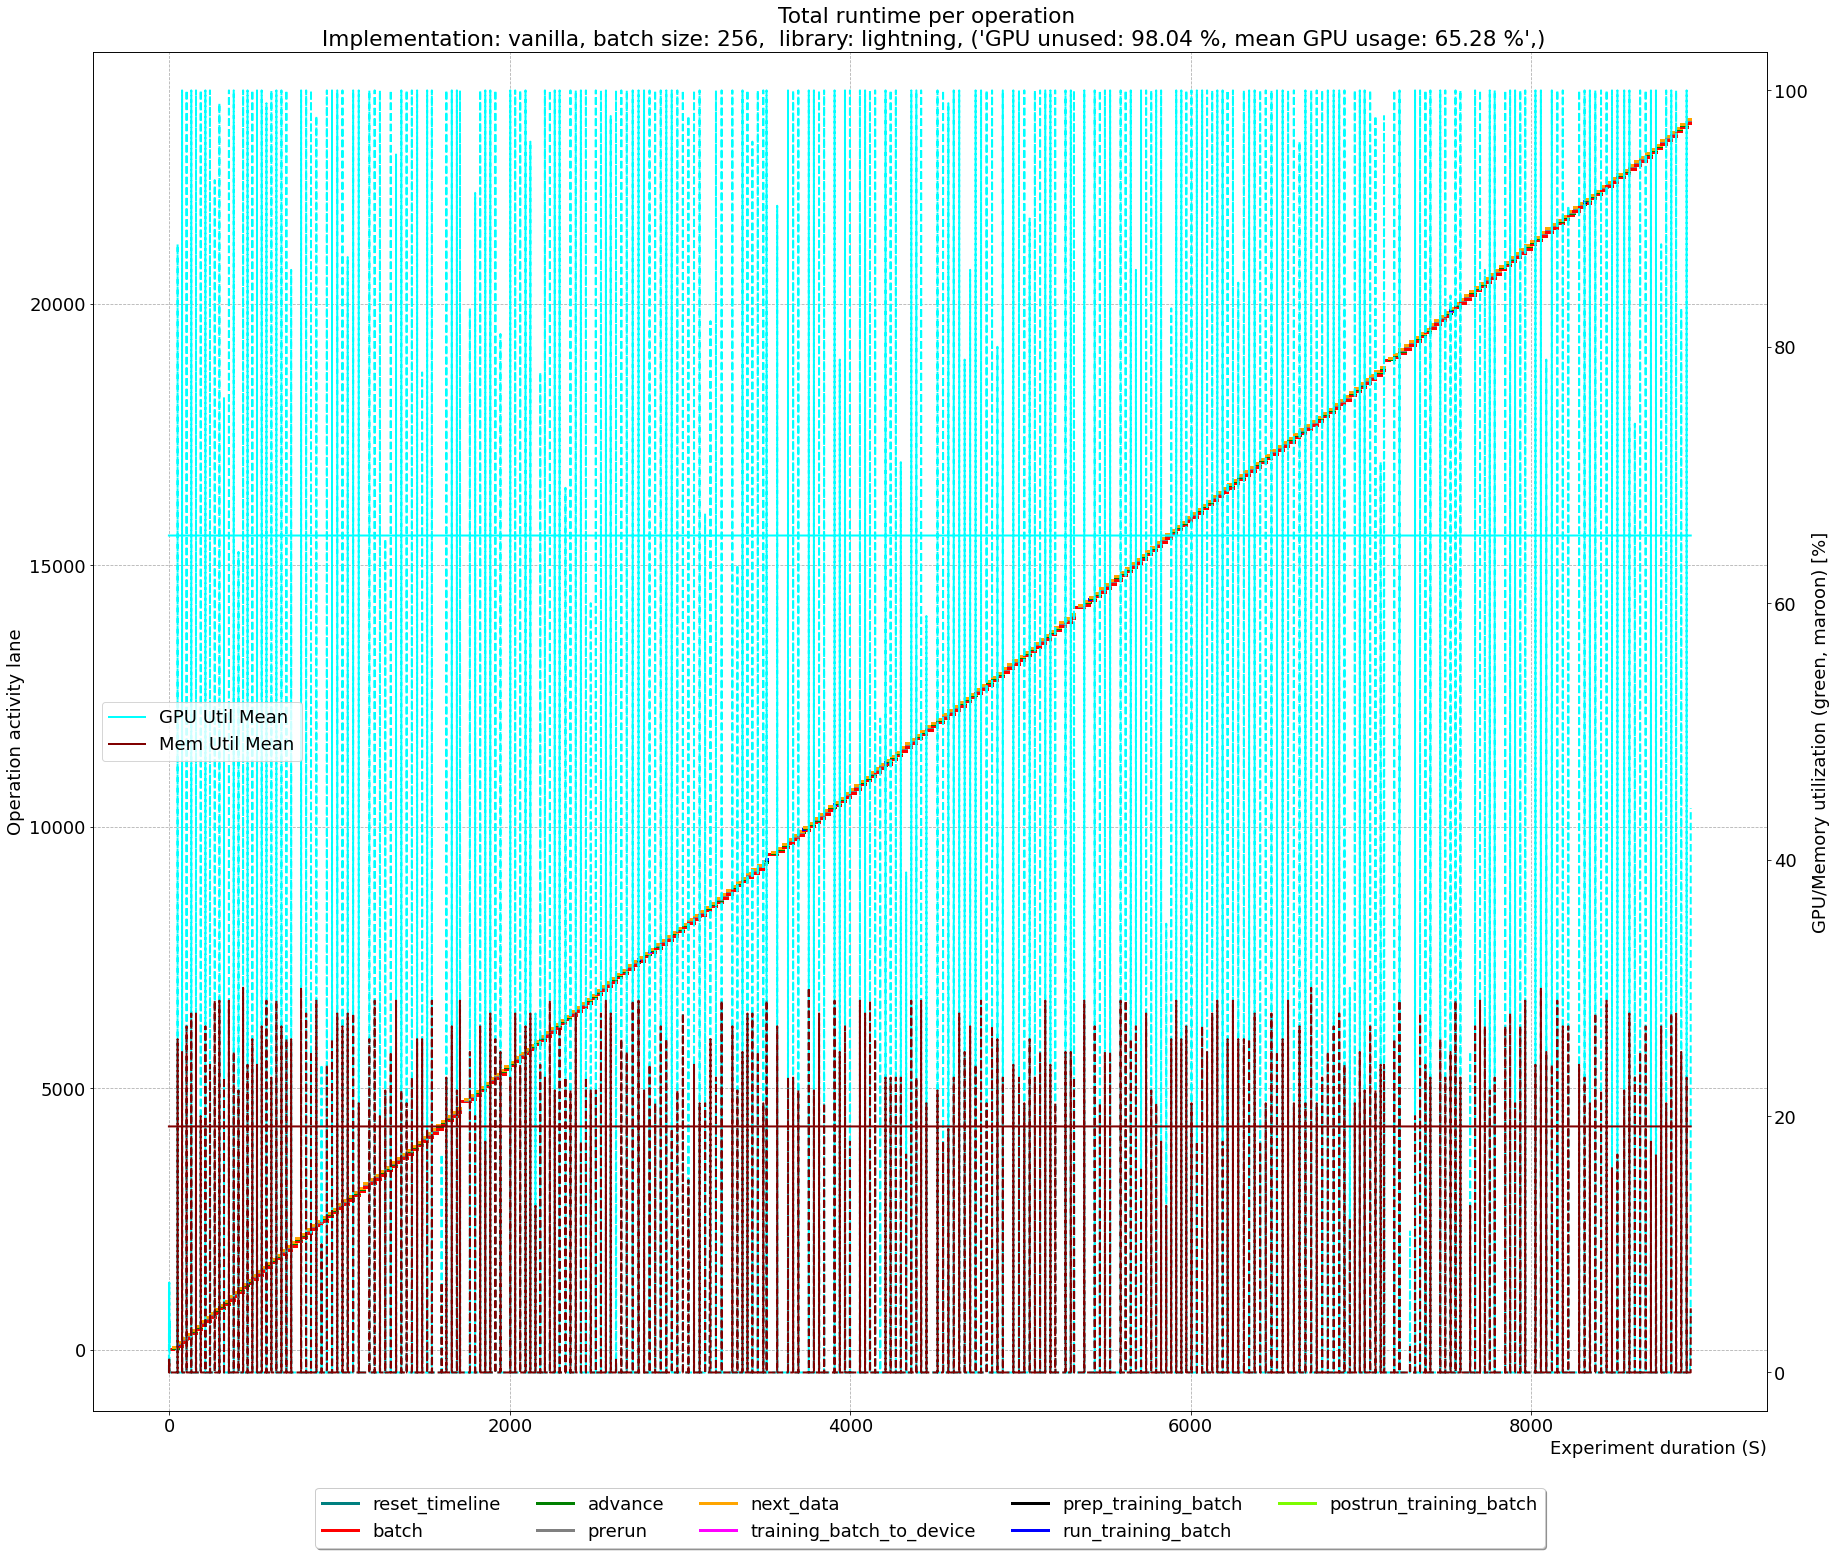

In [146]:
unique_runs_s3, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_s3)
returns_s3 = []

for run in sorted(unique_runs_s3):
    df = df_dataloader_s3[df_dataloader_s3["run"]==run]
    dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False) 
    result = show_timelines_with_gpu(df=df, gpu_util=dfgpu, lanes=lanes, colors=colors, run=run, 
                                     flat=False, show_gpu=True, zoom=False, zoom_epochs=2,
                                     skip_plot=False, ms=True)
    result["run"]=run
    returns_s3.append(result)

### Plot function timelines for local storage

timestamp_2 True
74.78413284132841 41.832692307692305


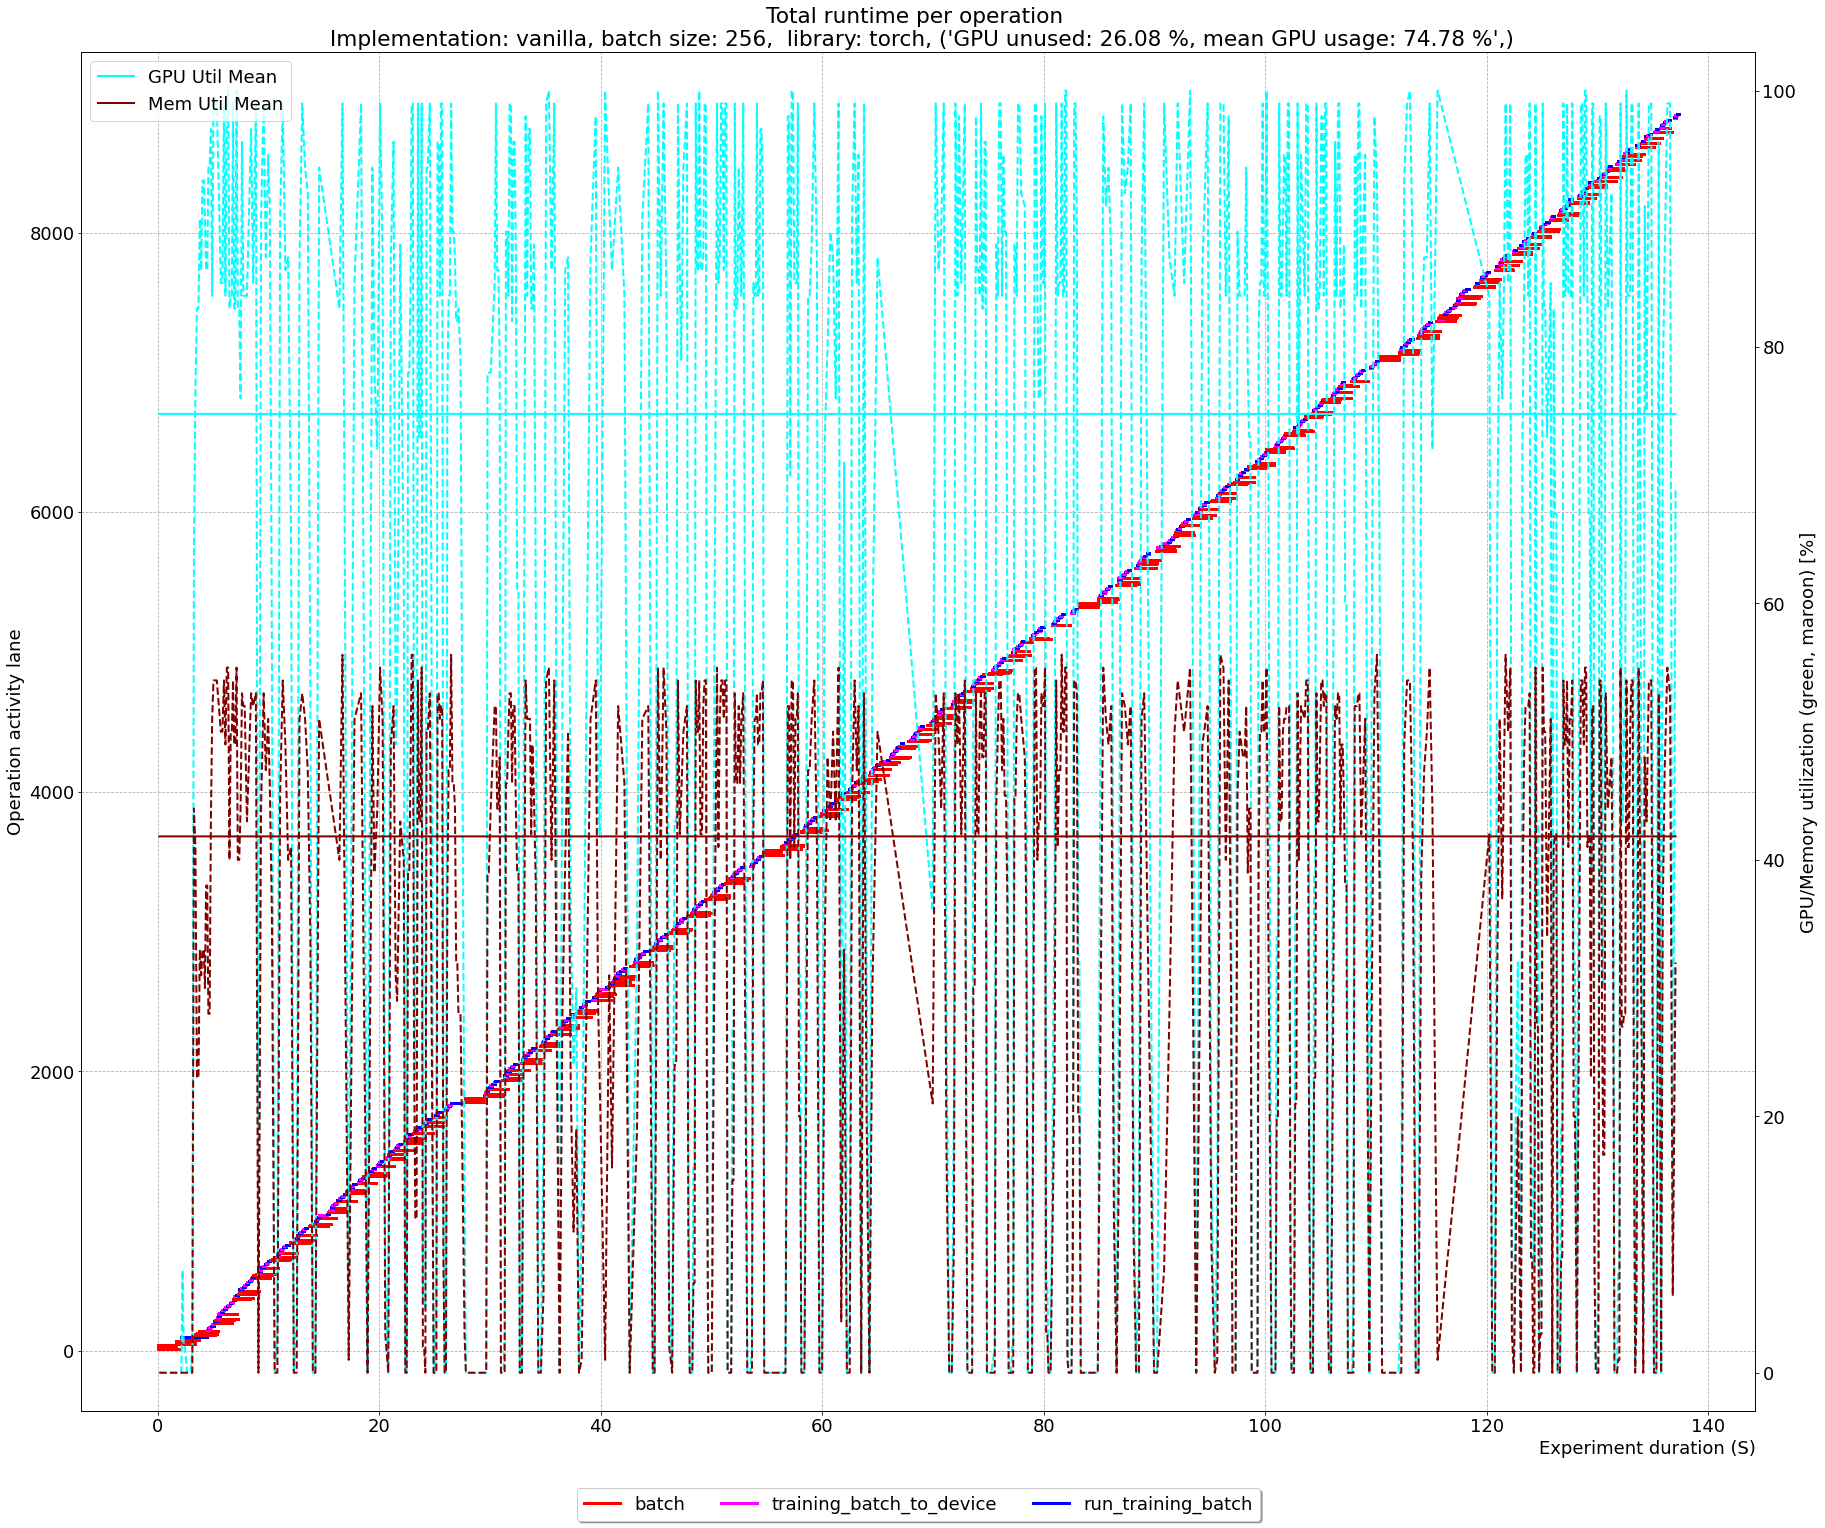

timestamp_2 True
64.67509336397588 18.926790785736827


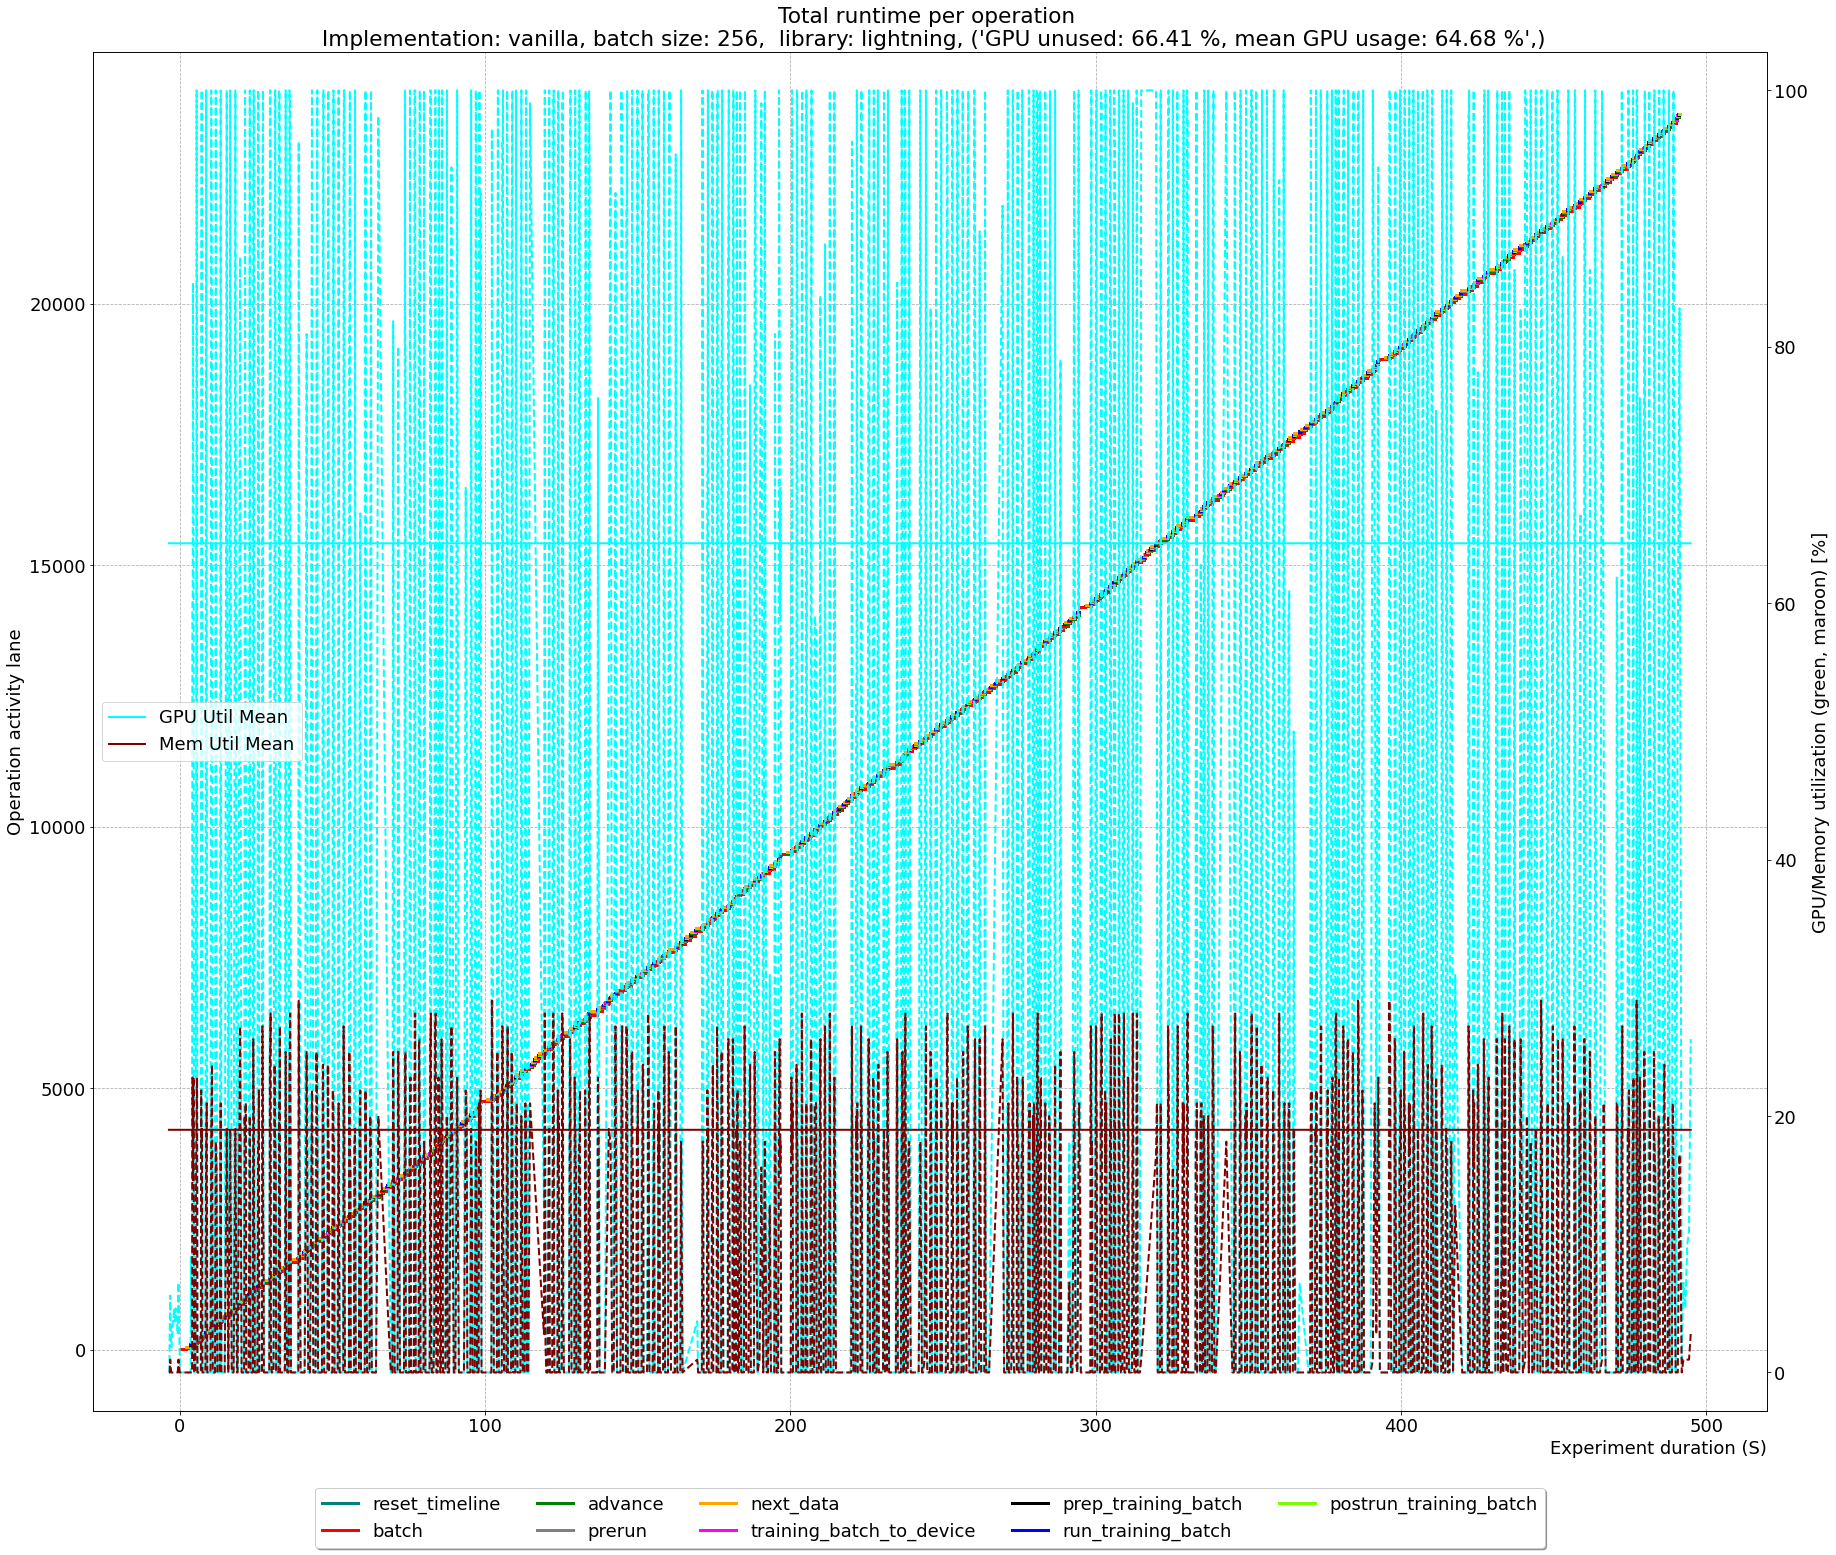

In [147]:
unique_runs_scratch, unique_functions, colors, lanes = get_colors_runs_and_lanes(df_dataloader_scratch)
returns_scratch = []

for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
    dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False)
    result = show_timelines_with_gpu(df=df, gpu_util=dfgpu, lanes=lanes, colors=colors, run=run, 
                                     flat=False, show_gpu=True, zoom=False, zoom_epochs=2,
                                     skip_plot=False, ms=True)
    result["run"]=run
    returns_scratch.append(result)

Get unique runs to loop through, and plot the results

### Result tables
Print throughput in loaded images per second, and function duration in seconds, for S3 and Scratch

In [159]:
# sanity check
get_metadata_info(output_base_folder / "" / unique_runs_s3[0])

Dataset:  15000
Batch size: 256
Epochs:  5
Images total:  75000
Batches per epoch 59
Images total (rounded):  75520


In [160]:
print(unique_runs_s3)

['20220214f115431_benchmark_e2e_torch_s3_256_4_16_1_vanilla_sync'
 '20220214f123315_benchmark_e2e_lightning_s3_256_4_16_1_vanilla_sync']


In [161]:
df_full_s3 = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)
results_s3 = pd.DataFrame.from_records(data=returns_s3)
r = get_throughput(results_s3, "", df_full_s3, unique_runs_s3, output_base_folder)
r

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.36it/s]


runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0  2309.994297      95.441989               71.750791       1.773151   
1  8934.938077      98.040252               65.280305       0.340417   

   mem_util_mean_no_zeros implementation cache    library  throughput  \
0               41.055847        vanilla     1      torch  162.338063   
1               19.189588        vanilla     1  lightning   41.970073   

         dl_MB   imgs   Mbits/s      MB/s  
0  1109.475819  75000  3.842350  0.480294  
1  1109.475819  75000  0.993382  0.124173

In [162]:
df_full_scratch = extract_pandas(output_base_folder, folder_filter=scratch_folder_filter)
results_scratch = pd.DataFrame.from_records(data=returns_scratch)
r = get_throughput(results_scratch, "", df_full_scratch, unique_runs_scratch, output_base_folder)
r

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.53it/s]


runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0  137.243011      26.082509               74.784133      29.666553   
1  491.064960      66.406099               64.675093       5.788361   

   mem_util_mean_no_zeros implementation cache    library   throughput  \
0               41.832692        vanilla     1      torch  2732.379570   
1               18.926791        vanilla     1  lightning   763.646423   

         dl_MB   imgs    Mbits/s      MB/s  
0  1108.445913  75000  64.612159  8.076520  
1  1108.445913  75000  18.057829  2.257229